# KNN model for predicting impact position using datasets P1 based on **envelope** features - Sound

### Model Description

This notebook implements a K-Nearest Neighbors (KNN) model to predict the position of an impact (C, S, V) based on sound features extracted from audio files. The workflow involves reading `.wav` files, extracting the highest frequency **envelope** using FFT, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through scatter plots and a confusion matrix.

### Import libraries

In [22]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import sys

### Import Tool Functions

In [23]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

from readWavFolder import readWavFolder
from spectrumFromSignal import spectrumFromSignal
from envelope_from_signal import envelope_from_signal
p1_s_samples = "../../../Data/Sound/P1"

### Feature extraction example

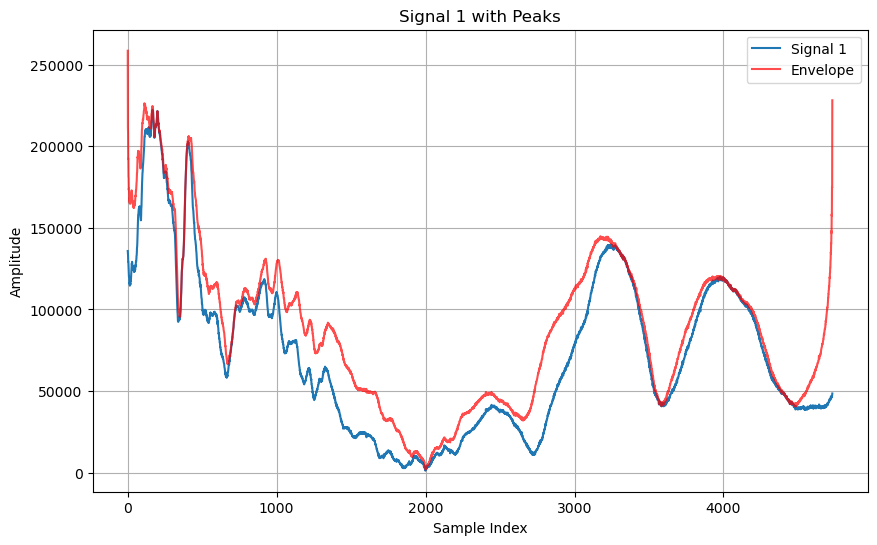

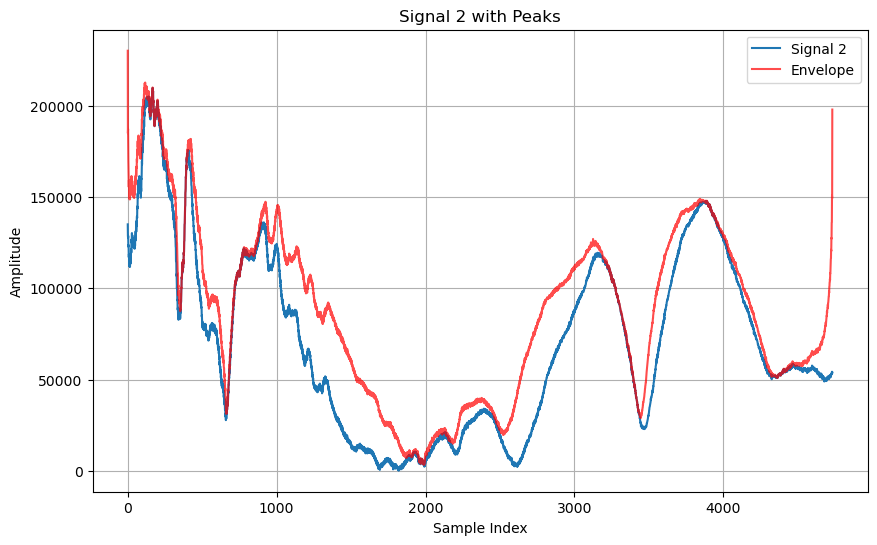

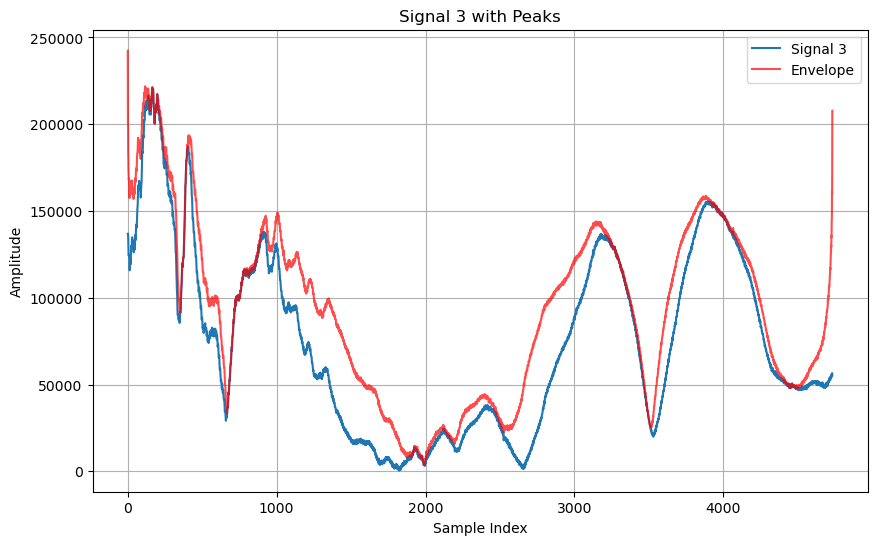

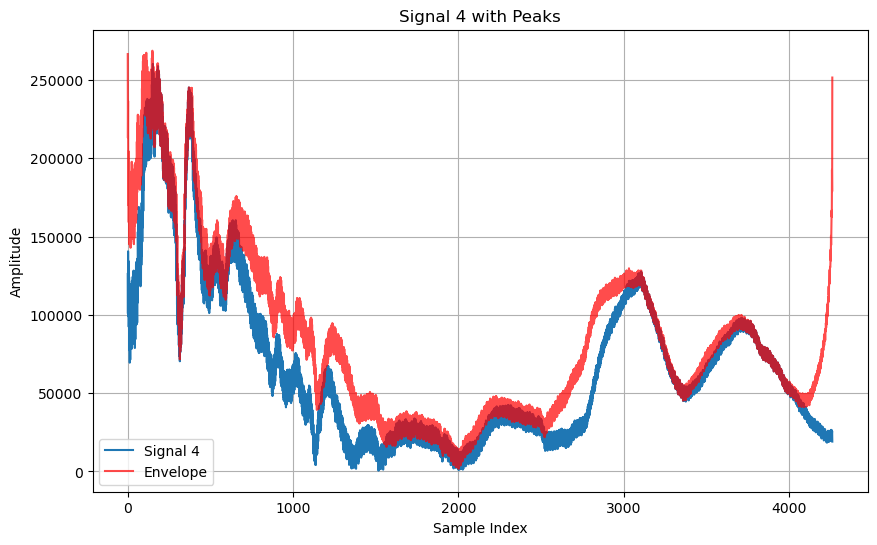

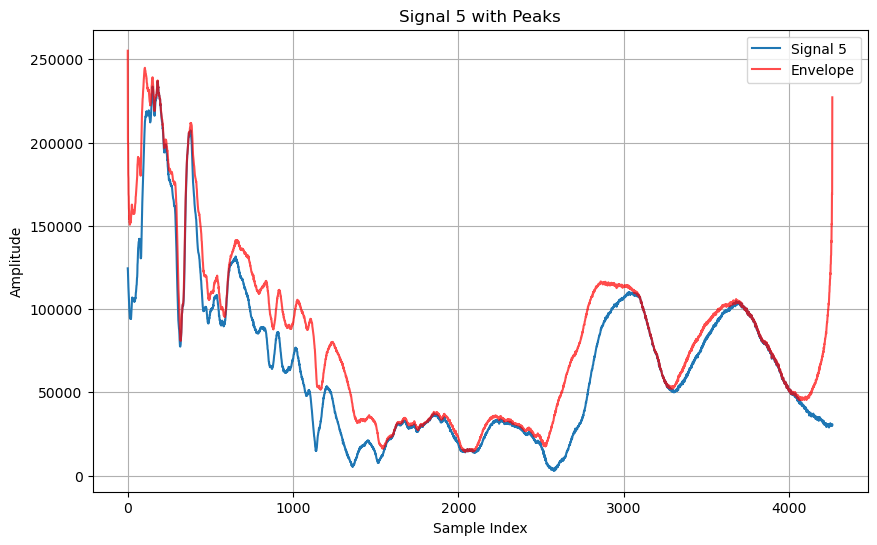

In [24]:
samplerateVect,testWavFileVect,files = readWavFolder("../../../Data/Sound/P1")

for idx in range(5):  # Loop through the first 5 elements
    spectrum, _ = spectrumFromSignal(testWavFileVect[idx], samplerateVect[idx])
    env = envelope_from_signal(spectrum)
    
    plt.figure(figsize=(10, 6))
    plt.plot(spectrum, label=f"Signal {idx + 1}")
    plt.plot(env, color="red", label="Envelope", alpha=0.7)
    plt.title(f"Signal {idx + 1} with Peaks")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

## Main

In [25]:
n_neighbors_range = range(1, 31, 3)
weights_options = ['uniform', 'distance']
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

results = []
X_envelope = []
Y_Label = []

samplerateVect, WavFileVect, filesName = readWavFolder("../../../Data/Sound/P1")

for i in range(len(WavFileVect)):
    spectrum, _ = spectrumFromSignal(WavFileVect[i], samplerateVect[i])
    env = envelope_from_signal(spectrum)
    X_envelope.append(env / np.max(env))  # Normalize the envelope data
    position = 1
    if "C" in filesName[i]:
        position = 1
    elif "S" in filesName[i]:
        position = 2
    elif "V" in filesName[i]:
        position = 3

    Y_Label.append(position)

# Pad X_envelope to make all samples the same length
max_length = max(len(env) for env in X_envelope)
X_envelope_padded = [np.pad(env, (0, max_length - len(env)), constant_values=0) for env in X_envelope]

# Convert to numpy arrays
X_envelope = np.array(X_envelope_padded)
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y_Label)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_envelope, Y, test_size=0.2, random_state=42)

for n_neighbors in n_neighbors_range:
    for weights in weights_options:
        for metric in metric_options:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            y_train_pred = knn.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)
            
            results.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })


results_df = pd.DataFrame(results)

### Save the results

In [27]:

if os.path.exists("results_sknn_envelope.xlsx"):
    os.remove("results_sknn_envelope.xlsx")
results_df.to_excel("results_sknn_envelope.xlsx", index=False)
print("Results have been saved to 'results_sknn_envelope.xlsx'.")

Results have been saved to 'results_sknn_envelope.xlsx'.


### Compute the best model

In [28]:
# Get the best configuration
best_config = results_df.loc[results_df['accuracy_test'].idxmax()]
best_n_neighbors = int(best_config['n_neighbors'])
best_weights = best_config['weights']
best_metric = best_config['metric']

print(f"Best Hyperparameters:")
print(f"  n_neighbors: {best_n_neighbors}")
print(f"  weights: {best_weights}")
print(f"  metric: {best_metric}")

# Extract features again for the best n_peak
X_envelope = []
Y_Label = []

for i in range(len(WavFileVect)):
    spectrum, _ = spectrumFromSignal(WavFileVect[i], samplerateVect[i])
    env = envelope_from_signal(spectrum)
    X_envelope.append(env / np.max(env))

    position = 1
    if "C" in filesName[i]:
        position = 1
    elif "S" in filesName[i]:
        position = 2
    elif "V" in filesName[i]:
        position = 3
    Y_Label.append(position)

max_length = max(len(env) for env in X_envelope)
X = [np.pad(env, (0, max_length - len(env)), constant_values=0) for env in X_envelope]
X = np.array(X)

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y_Label)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the KNN model with the best configuration
knn_best = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn_best.fit(X_train, y_train)

# Predict and visualize
y_pred_best = knn_best.predict(X_test)


Best Hyperparameters:
  n_neighbors: 1
  weights: uniform
  metric: manhattan


### Visualisation

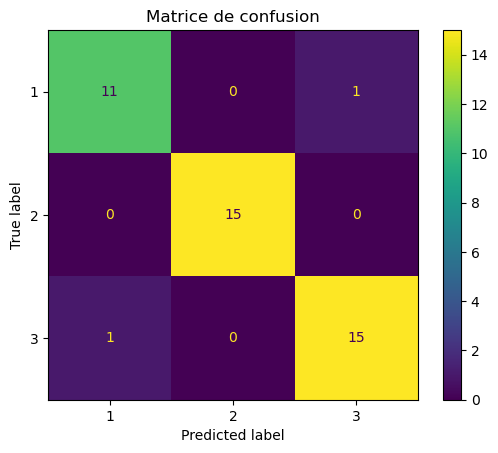

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()